<bold> <font size = '10'>  **Color clustering tool**  </font> </bold>

------

# Motivations

In my current job but also in past jobs, I often came across the recurring need of our clients to have qualitative insights on their social media presence. I am used to provide quantitative insights based on classic KPIs such as reach, impressions, engagement, etc. But what is trickier is to build a story to the client with qualitative insights without doing it manually (it takes a lot of time!). For example, some clients want to understand the communication strategy of their competitors in order to stand out from them. Do they have a specific tone of voice? Do they use the same set of colors to communicate?

This is how I got the idea to work on this project! The objective is to create a **color clustering tool which will extract the most used colors of an Instagram page.**

# Sources

This article helped me to build the K-Means clustering algorithm to extract the top colors of an image:
https://towardsdatascience.com/color-identification-in-images-machine-learning-application-b26e770c4c71

I found this article which was quite similar with what I had in mind for this project. This helped me to build the methodology to merge the data of all the pictures of an Instagram page. https://mode.com/blog/brand-colors-on-instagram/

I used this library to extract Instagram pictures: https://instaloader.github.io/

# Imports

In [1]:
import pandas as pd

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os

%matplotlib inline

In [3]:
import instaloader

In [4]:
import glob
from PIL import Image
import xlsxwriter
import os

In [5]:
import time as t

In [6]:
import colorsys as cs

In [7]:
from datetime import datetime
from itertools import dropwhile, takewhile

# Instagram image extraction + image analysis

#### What is the Instagram page name?

In [8]:
IG_page_name = input('What is the Instagram page name?')

What is the Instagram page name?burgerking


#### Instagram image extraction

In this part, I use the Instaloader library to extract the images (not the videos) of an Instagram page.

In [9]:
L = instaloader.Instaloader()

In [10]:
#L.login("login","password")

In [11]:
L = instaloader.Instaloader(download_videos = False,
                            download_video_thumbnails = False,
                            download_geotags = False,
                            download_comments = False,
                            save_metadata = False,
                            post_metadata_txt_pattern = "")
profile = instaloader.Profile.from_username(L.context, IG_page_name).get_posts()

I give the user the possibility to choose between collecting all the pictures of the Instagram page or restrict the collection to a specific timeframe. Instagram has limit rates which can be reached quickly if the Instagram page has too many posts. Selecting a specific timeframe (2020 only for example) can help to avoid reaching the limit. 

In [12]:
data_collection = input("Do you want to collect all the data or select a timeframe? (format: 'all data' or 'timeframe')")

if data_collection == "all data":
    for post in profile:
        L.download_post(post, IG_page_name)
        
elif data_collection == "timeframe":
    until_date = input("What is the start date? (format: X/X/20XX)")
    since_date = input("What is the end date? (format: X/X/20XX)")

    until_day = int(until_date.split(sep='/')[0])
    until_month = int(until_date.split(sep='/')[1])
    until_year = int(until_date.split(sep='/')[2])
    since_day = int(since_date.split(sep='/')[0])
    since_month = int(since_date.split(sep='/')[1])
    since_year = int(since_date.split(sep='/')[2])
    
    SINCE = datetime(since_year, since_month, since_day)
    UNTIL = datetime(until_year, until_month, until_day)

    for post in takewhile(lambda p: p.date > UNTIL, dropwhile(lambda p: p.date > SINCE, profile)):
        L.download_post(post, IG_page_name)

Do you want to collect all the data or select a timeframe? (format: 'all data' or 'timeframe')all data
burgerking/2021-01-15_00-01-58_UTC_1.jpg burgerking/2021-01-15_00-01-58_UTC_2.jpg burgerking/2021-01-15_00-01-58_UTC_3.jpg burgerking/2021-01-15_00-01-58_UTC_4.jpg 
burgerking/2021-01-08_22-35-22_UTC_1.jpg burgerking/2021-01-08_22-35-22_UTC_2.jpg burgerking/2021-01-08_22-35-22_UTC_3.jpg burgerking/2021-01-08_22-35-22_UTC_4.jpg burgerking/2021-01-08_22-35-22_UTC_5.jpg burgerking/2021-01-08_22-35-22_UTC_6.jpg burgerking/2021-01-08_22-35-22_UTC_7.jpg 

burgerking/2020-12-22_01-04-22_UTC.jpg 
burgerking/2020-12-20_16-40-38_UTC.jpg 

burgerking/2020-12-07_21-27-27_UTC_1.jpg burgerking/2020-12-07_21-27-27_UTC_2.jpg 
burgerking/2020-12-04_17-41-57_UTC_1.jpg burgerking/2020-12-04_17-41-57_UTC_2.jpg 
burgerking/2020-12-01_18-07-01_UTC_1.jpg burgerking/2020-12-01_18-07-01_UTC_2.jpg 
burgerking/2020-11-24_19-00-09_UTC.jpg 
burgerking/2020-11-17_16-07-34_UTC.jpg 
burgerking/2020-11-14_20-00-28_UT

burgerking/2018-10-22_13-59-54_UTC.jpg 
burgerking/2018-10-18_16-45-54_UTC.jpg 
burgerking/2018-10-16_18-09-37_UTC.jpg 

burgerking/2018-10-11_14-01-45_UTC.jpg 
burgerking/2018-10-02_14-11-17_UTC.jpg 
burgerking/2018-09-27_14-59-33_UTC.jpg 
burgerking/2018-09-24_14-31-30_UTC.jpg 
burgerking/2018-09-20_14-01-23_UTC.jpg 
burgerking/2018-09-18_15-51-48_UTC.jpg 
burgerking/2018-09-14_14-08-30_UTC.jpg 
burgerking/2018-09-11_15-06-37_UTC.jpg 
burgerking/2018-09-07_14-00-09_UTC.jpg 
burgerking/2018-09-04_16-03-13_UTC.jpg 
burgerking/2018-08-27_13-59-22_UTC.jpg 
burgerking/2018-08-24_14-10-07_UTC.jpg 
burgerking/2018-08-21_15-12-22_UTC.jpg 
burgerking/2018-08-16_13-58-51_UTC.jpg 
burgerking/2018-08-14_14-29-47_UTC.jpg 
burgerking/2018-08-08_14-28-26_UTC.jpg 
burgerking/2018-08-03_16-14-34_UTC.jpg 
burgerking/2018-07-31_16-16-01_UTC.jpg 
burgerking/2018-07-26_13-59-25_UTC.jpg 
burgerking/2018-07-23_14-28-05_UTC.jpg 
burgerking/2018-07-15_15-31-01_UTC.jpg 
burgerking/2018-07-09_13-00-46_UTC.jpg 

#### Image analysis functions

Here I define functions to treat the images and extract their top colors. I use the K-Means clustering Machine Learning algorithm. **I set the number of clusters to 3**. I decided to set it at 3 because I want to extract the top 3 colors of a picture. However, this might not be ideal for all the pictures (these which are rich in colors). The ideal approach here would be to perform the elbow method to select the perfect number of clusters for each picture. I keep this in mind for further enhancements of the code. My main goal in this project is to have a Minimum Viable Product.

Besides, the algorithm will be performed on resized pictures in order to reduce the code processing time.

In [13]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [14]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [15]:
def get_colors(image, number_of_colors, show_chart):
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)

    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]
    
    index_max_RGB = list(counts.values()).index(max(list(counts.values())))
    max_RGB = list(rgb_colors[index_max_RGB])
    
    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return max_RGB

#### For loop: Excel creation + image analysis

**This for loop is where all the magic happens!** An Excel file is created on which I keep track of each picture analysed and save their respective top RGB color (determined by the K-Means clustering algorithm).

In [16]:
#Start timer
start = t.time()

#Put all images of an Instagram page in an Excel file
images=glob.glob(IG_page_name+"/*.jpg")
workbook = xlsxwriter.Workbook('images_'+IG_page_name+'.xlsx')
worksheet = workbook.add_worksheet()
worksheet.set_column('A:B', 15)
worksheet.set_row(1, 70)
bold = workbook.add_format({'bold': True})

worksheet.write('A1', 'Image', bold)
worksheet.write('B1', 'R', bold)
worksheet.write('C1', 'G', bold)
worksheet.write('D1', 'B', bold)

i=2
for image in images:
    with Image.open(image) as img:
        width_100 = img.width
        height_100 = img.height
    width_30 = int(round(width_100 * 0.1, 0))
    img = Image.open(image)
    wpercent = (width_30/float(width_100))
    hsize = int((float(height_100)*float(wpercent)))
    img = img.resize((width_30,hsize), Image.ANTIALIAS)
    img_name = 'local'+str(i)+'.jpg'
    img.save(img_name)
    worksheet.set_row(i-1, hsize)
    worksheet.insert_image('A'+str(i), img_name)
    
    #Image analysis, get max RGB value and input in excel file
    max_RGB = get_colors(get_image(img_name), 3, False)
    worksheet.write('B'+str(i), max_RGB[0])
    worksheet.write('C'+str(i), max_RGB[1])
    worksheet.write('D'+str(i), max_RGB[2])
    
    i=i+1
    #break
    
workbook.close()

#Delete all images in file directory because temp images were created
for image in glob.glob("*.jpg"):
    os.remove(image)

#End timer
end = t.time()

#Duration timer
duration = end - start
if duration > 60:
    minutes = int(duration/60)
    seconds = int(duration - int(duration/60)*60)
    if minutes == 1:
        print("The code lasted", minutes, "minute and", seconds, "seconds.")
    else:
        print("The code lasted", minutes, "minutes and", seconds, "seconds.")
else:
    print("The code lasted", int(duration), "seconds.")

/Users/salim/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)


The code lasted 7 minutes and 3 seconds.


In [17]:
data = pd.read_excel('images_'+IG_page_name+'.xlsx')

In [18]:
data.head()

,Image,R,G,B
0,NaN,144.403221,93.195444,52.357260
1,NaN,223.474224,215.881888,205.600926
2,NaN,237.566201,232.551368,216.985598
3,NaN,89.362357,87.579111,43.520526
4,NaN,202.553669,141.304662,64.804900


#### RGB to HSL

In here, I need to translate the RGB values into HSL values. HSL (Hue, Saturation, Lightness) is another color model which is understandable by humans.
By itself, the HSL color model covers 3'600'000 colors. The objective in the next lines is to reduce the color range to 1'800 colors. The final goal is to group similar colors together. With more than 3 million colors, it is impossible to expect colors to be grouped together. Hence the color range reduction.

In [19]:
def round_to_tenth(n):
    rem = n % 10
    if rem < 5:
        n = int(n / 10) * 10
    else:
        n = int((n + 10) / 10) * 10
    return n

In [20]:
def round_to_twentieth(n):
    rem = n % 20
    if rem < 10:
        n = int(n / 20) * 20
    else:
        n = int((n + 20) / 20) * 20
    return n

In [21]:
data['H'] = 0
data['S'] = 0
data['L'] = 0
data['HSL'] = 0
for i in range(0,len(data)):
    data['H'].loc[i] = round_to_twentieth(cs.rgb_to_hls(data['R'].loc[i]/255,data['G'].loc[i]/255,data['B'].loc[i]/255)[0]*360)
    data['S'].loc[i] = round_to_tenth(cs.rgb_to_hls(data['R'].loc[i]/255,data['G'].loc[i]/255,data['B'].loc[i]/255)[2]*100)
    data['L'].loc[i] = round_to_tenth(cs.rgb_to_hls(data['R'].loc[i]/255,data['G'].loc[i]/255,data['B'].loc[i]/255)[1]*100)
    data['HSL'].loc[i] = str(data['H'].loc[i]),str(data['S'].loc[i]),str(data['L'].loc[i])
    
    

/Users/salim/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
data

,Image,R,G,B,H,S,L,HSL
0,NaN,144.403221,93.195444,52.357260,20,50,40,"(20, 50, 40)"
1,NaN,223.474224,215.881888,205.600926,40,20,80,"(40, 20, 80)"
2,NaN,237.566201,232.551368,216.985598,40,40,90,"(40, 40, 90)"
3,NaN,89.362357,87.579111,43.520526,60,30,30,"(60, 30, 30)"
4,NaN,202.553669,141.304662,64.804900,40,60,50,"(40, 60, 50)"
...,...,...,...,...,...,...,...,...
300,NaN,209.909930,8.682996,4.773038,0,100,40,"(0, 100, 40)"
301,NaN,197.193392,29.152129,36.604115,360,70,40,"(360, 70, 40)"
302,NaN,124.109855,70.066957,41.722703,20,50,30,"(20, 50, 30)"
303,NaN,32.705779,130.822406,53.630137,140,60,30,"(140, 60, 30)"


Here are the HSL values of the top 20 most used colors of the Instagram page.

In [23]:
data['HSL'].value_counts().head(20)

(20, 50, 50)    13
(40, 60, 60)    11
(20, 60, 20)    11
(20, 40, 50)     9
(20, 50, 40)     8
(20, 50, 20)     6
(40, 50, 90)     6
(20, 70, 20)     5
(40, 50, 50)     5
(40, 90, 50)     5
(20, 40, 40)     5
(20, 60, 50)     5
(20, 40, 20)     5
(20, 60, 30)     4
(40, 40, 90)     4
(40, 70, 60)     3
(40, 30, 90)     3
(40, 60, 70)     3
(0, 100, 40)     3
(20, 40, 60)     3
Name: HSL, dtype: int64

In [24]:
data['HSL'].nunique()

159

In here, I need to re-translate the HSL values to RGB values because the donut chart later is not able to understand HSL coordinates.

In [25]:
def hsl_to_rgb(a,b,c):
    value = tuple([round(x,2) for x in cs.hls_to_rgb(a/360, b/100, c/100)])
    return value

In [26]:
data['RGB rework'] = ''

for i in range(0,len(data)):
    data['RGB rework'].loc[i] = hsl_to_rgb(data['H'].loc[i],data['L'].loc[i],data['S'].loc[i])

In [27]:
data

,Image,R,G,B,H,S,L,HSL,RGB rework
0,NaN,144.403221,93.195444,52.357260,20,50,40,"(20, 50, 40)","(0.6, 0.33, 0.2)"
1,NaN,223.474224,215.881888,205.600926,40,20,80,"(40, 20, 80)","(0.84, 0.81, 0.76)"
2,NaN,237.566201,232.551368,216.985598,40,40,90,"(40, 40, 90)","(0.94, 0.91, 0.86)"
3,NaN,89.362357,87.579111,43.520526,60,30,30,"(60, 30, 30)","(0.39, 0.39, 0.21)"
4,NaN,202.553669,141.304662,64.804900,40,60,50,"(40, 60, 50)","(0.8, 0.6, 0.2)"
...,...,...,...,...,...,...,...,...,...
300,NaN,209.909930,8.682996,4.773038,0,100,40,"(0, 100, 40)","(0.8, 0.0, 0.0)"
301,NaN,197.193392,29.152129,36.604115,360,70,40,"(360, 70, 40)","(0.68, 0.12, 0.12)"
302,NaN,124.109855,70.066957,41.722703,20,50,30,"(20, 50, 30)","(0.45, 0.25, 0.15)"
303,NaN,32.705779,130.822406,53.630137,140,60,30,"(140, 60, 30)","(0.12, 0.48, 0.24)"


In [28]:
data['RGB rework'].value_counts()

(0.75, 0.42, 0.25)    13
(0.32, 0.16, 0.08)    11
(0.84, 0.68, 0.36)    11
(0.0, 0.0, 0.0)        9
(0.7, 0.43, 0.3)       9
                      ..
(0.95, 0.88, 0.85)     1
(0.12, 0.08, 0.12)     1
(0.84, 0.79, 0.76)     1
(0.11, 0.11, 0.09)     1
(0.21, 0.22, 0.18)     1
Name: RGB rework, Length: 143, dtype: int64

In [29]:
data_color_count = pd.DataFrame(data['RGB rework'].value_counts()).reset_index()
data_color_count.columns = ['RGB colors', 'Count']

In [30]:
data_color_count

,RGB colors,Count
0,"(0.75, 0.42, 0.25)",13
1,"(0.32, 0.16, 0.08)",11
2,"(0.84, 0.68, 0.36)",11
3,"(0.0, 0.0, 0.0)",9
4,"(0.7, 0.43, 0.3)",9
...,...,...
138,"(0.95, 0.88, 0.85)",1
139,"(0.12, 0.08, 0.12)",1
140,"(0.84, 0.79, 0.76)",1
141,"(0.11, 0.11, 0.09)",1


#### Pie chart creation

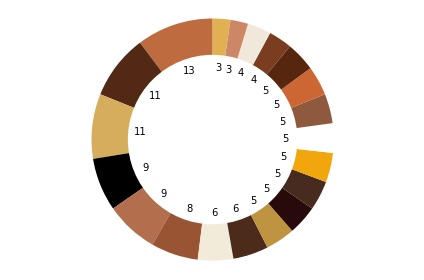

In [31]:
# Pie chart
sizes = list(data_color_count['Count'].head(20))
#colors
colors = list(data_color_count['RGB colors'].head(20))
fig1, ax1 = plt.subplots()

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(p=pct,v=val)
    return my_autopct

ax1.pie(sizes, colors = colors, autopct=make_autopct(sizes), startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.savefig(IG_page_name+'_plot.png')
plt.show()

I hope you will find this project useful!

https://github.com/SalimAmarti

**Salim Amarti**